# Insurance case

*Compiled by P. Wojewnik based on:*

*"Optimization of Damage Portfolio" by K. Saduś, M. Kwiecień, R. Lipiński* and *"ABC Company's Motor Insurance" by A. Kołota, M. Mączyńska*

The CEO Marcin R. of the insurance company PiTU S.A., Marcin R. wants to introduce a new car insurance for high risk drivers with higher damage rate but also higher raise prices for them.

Marcin R. calls the actuary – Aldona P., but he is in for a surprise. *My son got sick... The flu is nothing serious... But in its swine form, it can be dangerous.* With a heavy heart, Marcin sends Aldona home, and the task is given to Marek T., Aldona's assistant. The question is: **is a premium of 500 PLN sufficient?**

PiTU S.A.'s previous experiences with high risk drivers as follows:

| Number of Claims | Number of Policies |
|------------------|--------------------|
| 0                | 3,437              |
| 1                | 522                |
| 2                | 40                 |
| 3                | 2                  |
| 4                | 0                  |
| 5                | 0                  |

| Claim Amount     | Number of Claims   |
|------------------|--------------------|
| -                | 0                  |
| 100              | 0                  |
| 200              | 2                  |
| 500              | 27                 |
| 1,000            | 52                 |
| 2,000            | 115                |
| 5,000            | 203                |
| 10,000           | 106                |
| 20,000           | 42                 |
| 40,000           | 14                 |
| 50,000           | 0                  |
| 55,000           | 0                  |
| 60,000           | 1                  |

Aldona mentioned over the phone that **the number of claims is well described by a Poisson distribution**, while **the claim amounts follow a log-normal distribution**. Marcin managed to extract the **expected number of clients – 100** – and the **current surplus of 10,000**.

**Questions:**
1. What premium should be set to ensure that PiTU S.A. does not face ruin due to drivers?
2. Will the final surplus be equal to the initial surplus?
3. What is the risk of ruin?
4. What should the surplus and premium be to ensure the probability of ruin is less than 0.01?

## Hypothesis testing and parameter estimation

In [4]:
import Pkg
Pkg.add("VegaLites")

LoadError: The following package names could not be resolved:
 * VegaLites (not found in project, manifest or registry)
[36m   Suggestions:[39m [0m[1mV[22m[0m[1me[22m[0m[1mg[22m[0m[1ma[22m[0m[1mL[22m[0m[1mi[22m[0m[1mt[22m[0m[1me[22m [0m[1mV[22m[0m[1me[22m[0m[1mg[22m[0m[1ma[22mDatasets TeaFiles Recruiters

In [5]:
using Plots
using Distributions
using HypothesisTests
using Random
using DataFrames
using VegaLite

In [6]:
claim_count_freq = Dict(0 => 3437,
                1 => 522,
                2 => 40,
                3 => 2,
                4 => 0, 
                5 => 0);

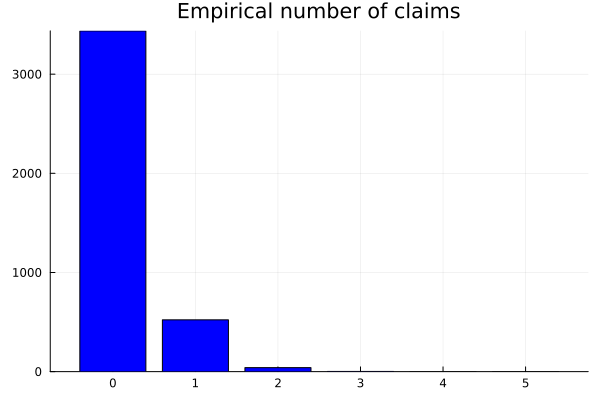

In [7]:
# Average number of claims
insurance_policies_total = sum(values(claim_count_freq))
avg_claim_count = (sum([x * y for (x, y) in claim_count_freq]) / 
                        insurance_policies_total)

# Does the number of claims follow Poisson distribution? 
poiss = Poisson(avg_claim_count)
k = length(claim_count_freq)-1
poisson_test = pdf.(poiss, 0:k) * insurance_policies_total

bar(claim_count_freq, fillcolor = :blue, legend=false, title= "Empirical number of claims")

In [8]:
println(avg_claim_count)
println(pdf.(poiss, 0:k))
println(claim_count_freq)
println([claim_count_freq[i] for i in 0:k])
print(poisson_test)

0.1519620094976256
[0.85902091475733, 0.1305385444070124, 0.009918449762492322, 0.0005024091856698595, 1.9086777361114376e-5, 5.80093008525747e-7]
Dict(0 => 3437, 4 => 0, 5 => 0, 2 => 40, 3 => 2, 1 => 522)
[3437, 522, 40, 2, 0, 0]
[3436.9426799440776, 522.2847161724566, 39.68371749973178, 2.0101391518651077, 0.07636619622181862, 0.002320952127111514]

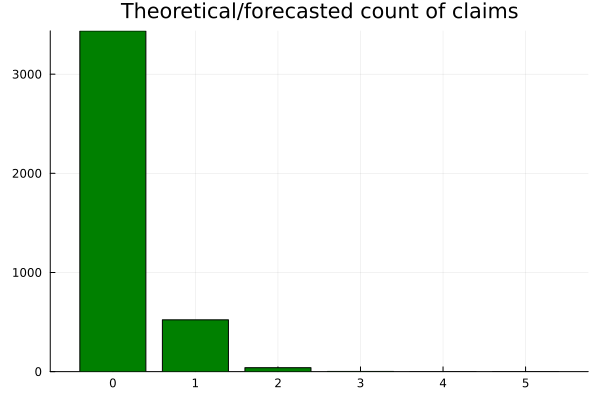

In [9]:
bar(0:k, poisson_test, fillcolor = :green, legend = false, title = "Theoretical/forecasted count of claims")

In [10]:
# chi-square test from HypothesisTests answers this question
χ = ChisqTest([claim_count_freq[i] for i in 0:k],poisson_test/sum(poisson_test));
pval = pvalue(χ)
println("p-value=",pval)
if pval > 0.05
    print("No evidence to reject a null hypothesis")
else
    print("Null hypothesis should be rejected")
end

p-value=0.9999022759058723
No evidence to reject a null hypothesis

## Claim amount

In [12]:
claim_amounts = [parse(Int,x[2]) for x in split.(readlines("./claim_amounts.txt"), ';')];

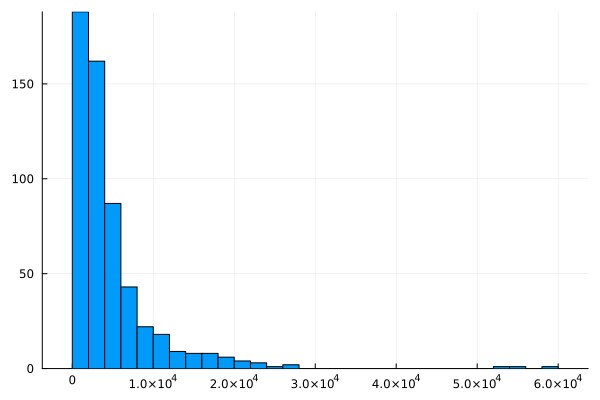

In [13]:
histogram(claim_amounts, legend = false, bins = 50)

In [14]:
println("Average claim amount: ", round(mean(claim_amounts)))

Average claim amount: 4742.0


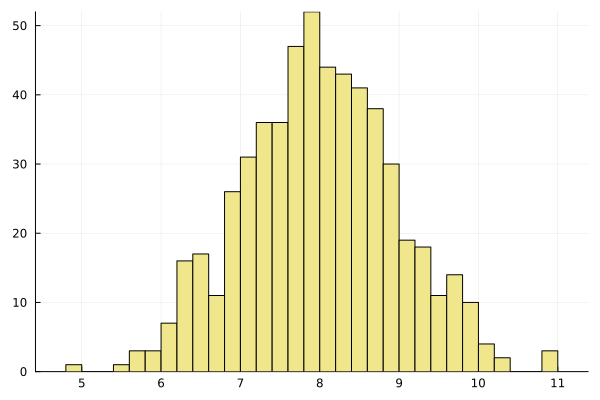

In [15]:
# Do claim amounts are distributed according to log-normal distribution?:
claim_amounts_ln = log.(claim_amounts);
histogram(claim_amounts_ln, fillcolor=:khaki, legend = false, bins = 50)

In [16]:
# Kolmogorov-Smirnov test answers this question
kstest = ExactOneSampleKSTest(claim_amounts_ln, Normal(mean(claim_amounts_ln), std(claim_amounts_ln)))
kspval = pvalue(kstest)
if kspval > 0.05
    println("p-value is:", kspval, 
           "\nNo evidence to reject a null hypothesis that claim amounts follow log-normal distribution")
else
    println("Null hypothesis should be rejected")
end

┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68


p-value is:0.9970804174500004
No evidence to reject a null hypothesis that claim amounts follow log-normal distribution


In [17]:
# Distribution parameters used later in simulations:
AVG_CLAIM_AMOUNT_LN = mean(claim_amounts_ln)
println("AVG_CLAIM_AMOUNT_LN = ", AVG_CLAIM_AMOUNT_LN)
STD_CLAIM_AMOUNT_LN = std(claim_amounts_ln)
println("STD_CLAIM_AMOUNT_LN = ", STD_CLAIM_AMOUNT_LN)

AVG_CLAIM_AMOUNT_LN = 7.995364814357663
STD_CLAIM_AMOUNT_LN = 0.9653333084236332


In [18]:
SIMULATION_NUMBER = 100
CLIENTS_NUMBER = 100
TIME_HORIZON = 2 # Simulatated time period in years

2

## Simulation model

In [20]:
function model(clients_number::S, 
                avg_claim_count::T, 
                avg_claim_amount_ln::T, 
                std_claim_amount_ln::T, 
                time_horizon::S, 
                surplus::T, 
                insurance_premium::T;
                seed::S=-1) where {T<:AbstractFloat, S<:Int}

    # Common Random Numbers in order to compare diverse scenarios:
    seed == -1 || Random.seed!(seed) 

    # we define the start date of insurance policies in our simulation:
    start_dates_of_insur_polic = [rand(1:365) for i in 1:clients_number]
    premium_paid_calendar = zeros(Int,365)
    for start_date in start_dates_of_insur_polic
        premium_paid_calendar[start_date] += 1
    end
    # We simulate/gerenerate the count of claims for each client according to Poisson distribution 
    claim_counts = rand(Poisson(avg_claim_count),clients_number)
    
    # We simulate claim dates for each client:
    claim_calendar = zeros(Int,365*time_horizon) 
    for k in 1:clients_number
        for s in 1:claim_counts[k]
            claim_date = start_dates_of_insur_polic[k] + rand(1:365)
            claim_calendar[claim_date] += 1
        end
    end
    
    
    # Simulation of claim amounts
    for day in 1:365*time_horizon
        day ≤ 364 && (surplus += premium_paid_calendar[day] * insurance_premium)
        claims_number = claim_calendar[day]
        claim_amount = sum(exp.(rand(Normal(avg_claim_amount_ln,std_claim_amount_ln),claims_number)))
        surplus -= claim_amount
        surplus < 0 && return surplus
        #println("Day: ", day, " Surplus: ", surplus)
    end
    return surplus
end

model (generic function with 1 method)

In [21]:
model(100,avg_claim_count, AVG_CLAIM_AMOUNT_LN, STD_CLAIM_AMOUNT_LN,TIME_HORIZON,10000.0,1300.0;seed=2)

34624.80404339424

In [22]:
function sim_experiment(surplus::T, insurance_premium::T, simulation_number::S, 
              clients_number::S, avg_claim_count::T, 
              avg_claim_amount_ln::T, std_claim_amount_ln::T, time_horizon::S) where {T<:AbstractFloat,S<:Int}
    surpluses = []
    for seed in 1:simulation_number
        
        push!(surpluses, model(clients_number, avg_claim_count, 
                           avg_claim_amount_ln, std_claim_amount_ln, time_horizon, 
                           surplus, insurance_premium, seed = seed))
    end

    return (ruin_count = sum(surpluses.<0), insolvency_risk = sum(surpluses.<0)/simulation_number, 
            surplus_condition_avg = mean(surpluses))
end   

sim_experiment (generic function with 1 method)

## Simulation experiments

### 1st attempt

In [25]:
surplus_range = 10000.0:10000.0:10000.0
premium_range = 500.0:50.0:1000.0

500.0:50.0:1000.0

In [26]:
CLIENTS_NUMBER

100

In [27]:
# empty vectors to store results
surplus_condition_avgs = [] 
insolvency_risks = []
ruin_counts = [] 

for surplus in surplus_range, premium in premium_range
    results = sim_experiment(surplus, premium, SIMULATION_NUMBER, 
                             CLIENTS_NUMBER, avg_claim_count, 
                             AVG_CLAIM_AMOUNT_LN, STD_CLAIM_AMOUNT_LN, TIME_HORIZON)
    push!(ruin_counts, results.ruin_count)
    push!(insolvency_risks, results.insolvency_risk)
    push!(surplus_condition_avgs, results.surplus_condition_avg)
    println("Surplus: ", surplus, "Premium: ", premium, 
              " Ruin count: ", results.ruin_count, " Conditional average of surplus: ",
              round(results.surplus_condition_avg), " Insolvency risk: ", results.insolvency_risk)
end

Surplus: 10000.0Premium: 500.0 Ruin count: 60 Conditional average of surplus: 2249.0 Insolvency risk: 0.6
Surplus: 10000.0Premium: 550.0 Ruin count: 56 Conditional average of surplus: 4720.0 Insolvency risk: 0.56
Surplus: 10000.0Premium: 600.0 Ruin count: 49 Conditional average of surplus: 8089.0 Insolvency risk: 0.49
Surplus: 10000.0Premium: 650.0 Ruin count: 40 Conditional average of surplus: 10967.0 Insolvency risk: 0.4
Surplus: 10000.0Premium: 700.0 Ruin count: 35 Conditional average of surplus: 14610.0 Insolvency risk: 0.35
Surplus: 10000.0Premium: 750.0 Ruin count: 30 Conditional average of surplus: 17979.0 Insolvency risk: 0.3
Surplus: 10000.0Premium: 800.0 Ruin count: 26 Conditional average of surplus: 22077.0 Insolvency risk: 0.26
Surplus: 10000.0Premium: 850.0 Ruin count: 21 Conditional average of surplus: 25970.0 Insolvency risk: 0.21
Surplus: 10000.0Premium: 900.0 Ruin count: 19 Conditional average of surplus: 30341.0 Insolvency risk: 0.19
Surplus: 10000.0Premium: 950.0 Rui

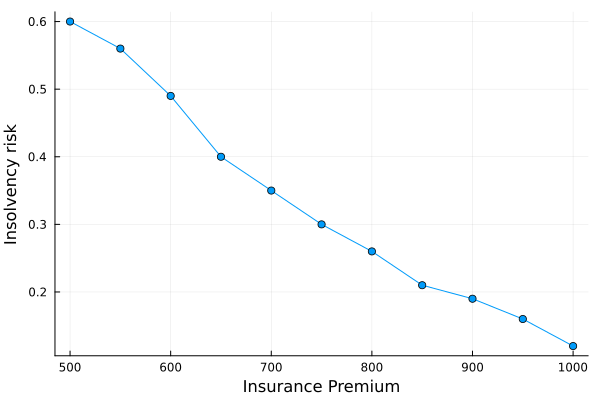

In [28]:
#ENV["GKS_ENCODING"] = "utf-8"      
plot(collect(premium_range), insolvency_risks, markershape=:circle,
ylabel = "Insolvency risk",
xlabel = "Insurance Premium",
legend = false)

### 2nd attempt

In [30]:
# Surplus and premium range
surplus_range = 10000.0:10000.0:10000.0
premium_range = 1000.0:50.0:2000.0

# empty vectors to store results
surplus_condition_avgs = [] 
insolvency_risks = []
ruin_counts = [] 

for surplus in surplus_range, premium in premium_range
    results = sim_experiment(surplus, premium, SIMULATION_NUMBER, 
                             CLIENTS_NUMBER, avg_claim_count, 
                             AVG_CLAIM_AMOUNT_LN, STD_CLAIM_AMOUNT_LN, TIME_HORIZON)
    push!(ruin_counts, results.ruin_count)
    push!(insolvency_risks, results.insolvency_risk)
    push!(surplus_condition_avgs, results.surplus_condition_avg)
    println("Surplus: ", surplus, "Premium: ", premium, 
              " Ruin count: ", results.ruin_count, " Conditional average of surplus: ",
              round(results.surplus_condition_avg), " Insolvency risk: ", results.insolvency_risk)
end

Surplus: 10000.0Premium: 1000.0 Ruin count: 12 Conditional average of surplus: 39127.0 Insolvency risk: 0.12
Surplus: 10000.0Premium: 1050.0 Ruin count: 8 Conditional average of surplus: 43806.0 Insolvency risk: 0.08
Surplus: 10000.0Premium: 1100.0 Ruin count: 7 Conditional average of surplus: 48588.0 Insolvency risk: 0.07
Surplus: 10000.0Premium: 1150.0 Ruin count: 4 Conditional average of surplus: 53455.0 Insolvency risk: 0.04
Surplus: 10000.0Premium: 1200.0 Ruin count: 3 Conditional average of surplus: 58347.0 Insolvency risk: 0.03
Surplus: 10000.0Premium: 1250.0 Ruin count: 3 Conditional average of surplus: 63184.0 Insolvency risk: 0.03
Surplus: 10000.0Premium: 1300.0 Ruin count: 2 Conditional average of surplus: 68104.0 Insolvency risk: 0.02
Surplus: 10000.0Premium: 1350.0 Ruin count: 1 Conditional average of surplus: 72998.0 Insolvency risk: 0.01
Surplus: 10000.0Premium: 1400.0 Ruin count: 1 Conditional average of surplus: 77985.0 Insolvency risk: 0.01
Surplus: 10000.0Premium: 14

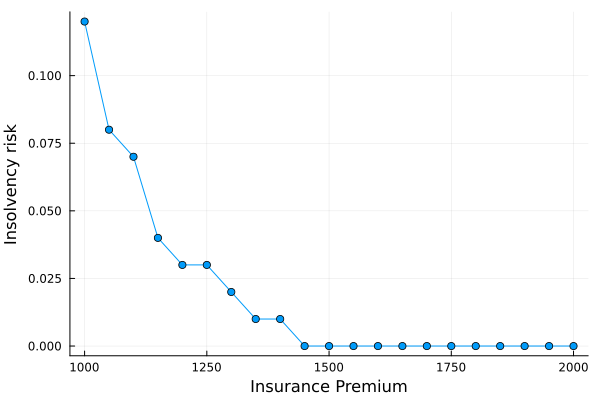

In [31]:
#ENV["GKS_ENCODING"] = "utf-8"      
plot(collect(premium_range), insolvency_risks, markershape=:circle,
ylabel = "Insolvency risk",
xlabel = "Insurance Premium",
legend = false)

### 3rd attempt

In [33]:
# Surplus and premium range
surplus_range = 10000.0:10000.0:10000.0
premium_range = 1400.0:10.0:1500.0

# empty vectors to store results
surplus_condition_avgs = [] 
insolvency_risks = []
ruin_counts = [] 

for surplus in surplus_range, premium in premium_range
    results = sim_experiment(surplus, premium, SIMULATION_NUMBER, 
                             CLIENTS_NUMBER, avg_claim_count, 
                             AVG_CLAIM_AMOUNT_LN, STD_CLAIM_AMOUNT_LN, TIME_HORIZON)
    push!(ruin_counts, results.ruin_count)
    push!(insolvency_risks, results.insolvency_risk)
    push!(surplus_condition_avgs, results.surplus_condition_avg)
    println("Surplus: ", surplus, "Premium: ", premium, 
              " Ruin count: ", results.ruin_count, " Average of surplus: ",
              round(results.surplus_condition_avg), " Insolvency risk: ", results.insolvency_risk)
end

Surplus: 10000.0Premium: 1400.0 Ruin count: 1 Average of surplus: 77985.0 Insolvency risk: 0.01
Surplus: 10000.0Premium: 1410.0 Ruin count: 1 Average of surplus: 78982.0 Insolvency risk: 0.01
Surplus: 10000.0Premium: 1420.0 Ruin count: 1 Average of surplus: 79980.0 Insolvency risk: 0.01
Surplus: 10000.0Premium: 1430.0 Ruin count: 0 Average of surplus: 80977.0 Insolvency risk: 0.0
Surplus: 10000.0Premium: 1440.0 Ruin count: 0 Average of surplus: 81975.0 Insolvency risk: 0.0
Surplus: 10000.0Premium: 1450.0 Ruin count: 0 Average of surplus: 82972.0 Insolvency risk: 0.0
Surplus: 10000.0Premium: 1460.0 Ruin count: 0 Average of surplus: 83969.0 Insolvency risk: 0.0
Surplus: 10000.0Premium: 1470.0 Ruin count: 0 Average of surplus: 84967.0 Insolvency risk: 0.0
Surplus: 10000.0Premium: 1480.0 Ruin count: 0 Average of surplus: 85964.0 Insolvency risk: 0.0
Surplus: 10000.0Premium: 1490.0 Ruin count: 0 Average of surplus: 86962.0 Insolvency risk: 0.0
Surplus: 10000.0Premium: 1500.0 Ruin count: 0 A

**=> So the Premium should be set larger than `1430` in order to ensure that PiTU S.A. does not face ruin due to drivers**

In [35]:
# Surplus and premium range
surplus = 10000.0
premium = 500.0

# Run simulation
results = sim_experiment(surplus, premium, SIMULATION_NUMBER, 
                             CLIENTS_NUMBER, avg_claim_count, 
                             AVG_CLAIM_AMOUNT_LN, STD_CLAIM_AMOUNT_LN, TIME_HORIZON)

# Print result
println("Initial surplus: ", surplus)
println("Premium: ", premium)
println("Ruin count: ", results.ruin_count)
println("Insolvency risk: ", results.insolvency_risk)
println("Average final surplus: ", round(results.surplus_condition_avg, digits=2))

# Check with initial surplus
diff = results.surplus_condition_avg - surplus
if abs(diff) < 100  
    println("Average final surplus ≈ initial ⇒ Premium ≈ enough to balance.")
elseif diff > 0
    println("Average final surplus > initial ⇒ Premium has profit.")
else
    println("Average final surplus < initial ⇒ Premium loss average.")
end

Initial surplus: 10000.0
Premium: 500.0
Ruin count: 60
Insolvency risk: 0.6
Average final surplus: 2248.91
Average final surplus < initial ⇒ Premium loss average.


Setting the premium of `500` as Marcin asking will make:  

- **The average final surplus is smaller than the initial surplus**
- **The ruin risk will be `60%`**

In [37]:
# Range
surplus_range = 0.0:1000.0:15000.0
premium_range = 1000.0:50.0:2000.0

# Initiate risk matrix
results_df = DataFrame(surplus=Float64[], premium=Float64[], ruin_risk=Float64[], safe_zone=Bool[])

# Run simulation
for surplus in surplus_range, premium in premium_range
    result = sim_experiment(surplus, premium, SIMULATION_NUMBER,
                            CLIENTS_NUMBER, avg_claim_count,
                            AVG_CLAIM_AMOUNT_LN, STD_CLAIM_AMOUNT_LN, TIME_HORIZON)

    ruin_risk = result.insolvency_risk
    is_safe = ruin_risk < 0.01

    push!(results_df, (surplus, premium, ruin_risk, is_safe))

    if is_safe
        println("SAFE: Surplus = $(surplus), Premium = $(premium), Ruin risk = $(round(ruin_risk, digits=4))")
    end
end

SAFE: Surplus = 0.0, Premium = 1650.0, Ruin risk = 0.0
SAFE: Surplus = 0.0, Premium = 1700.0, Ruin risk = 0.0
SAFE: Surplus = 0.0, Premium = 1750.0, Ruin risk = 0.0
SAFE: Surplus = 0.0, Premium = 1800.0, Ruin risk = 0.0
SAFE: Surplus = 0.0, Premium = 1850.0, Ruin risk = 0.0
SAFE: Surplus = 0.0, Premium = 1900.0, Ruin risk = 0.0
SAFE: Surplus = 0.0, Premium = 1950.0, Ruin risk = 0.0
SAFE: Surplus = 0.0, Premium = 2000.0, Ruin risk = 0.0
SAFE: Surplus = 1000.0, Premium = 1550.0, Ruin risk = 0.0
SAFE: Surplus = 1000.0, Premium = 1600.0, Ruin risk = 0.0
SAFE: Surplus = 1000.0, Premium = 1650.0, Ruin risk = 0.0
SAFE: Surplus = 1000.0, Premium = 1700.0, Ruin risk = 0.0
SAFE: Surplus = 1000.0, Premium = 1750.0, Ruin risk = 0.0
SAFE: Surplus = 1000.0, Premium = 1800.0, Ruin risk = 0.0
SAFE: Surplus = 1000.0, Premium = 1850.0, Ruin risk = 0.0
SAFE: Surplus = 1000.0, Premium = 1900.0, Ruin risk = 0.0
SAFE: Surplus = 1000.0, Premium = 1950.0, Ruin risk = 0.0
SAFE: Surplus = 1000.0, Premium = 2000

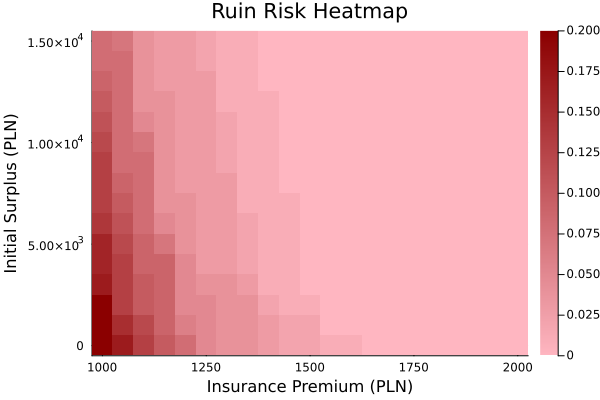

In [38]:
heatmap_matrix = reshape(results_df.ruin_risk, length(premium_range), length(surplus_range))'

# Plot heatmap
heatmap(
    premium_range, surplus_range, heatmap_matrix,
    xlabel = "Insurance Premium (PLN)",
    ylabel = "Initial Surplus (PLN)",
    cbar = true,
    color = :reds,
    title = "Ruin Risk Heatmap",
    legend = :right
)

## Individual Homework Assignment

### Examine the Company's Liquidity Depending on Parameters

---
Please answer the following questions by filling in the cells with your Julia code. Save the completed notebook and send it to mzawisz@sgh.waw.pl with the subject: [ASM] 3rd Homework Assignment.

__Submission Deadline:__ As indicated on Teams. Each day of delay costs 1 point less.

__Maximum Points Available:__ 5 points

---
**Questions**
**1. What is the minimum insurance premium (to the nearest 10 PLN) to ensure the probability of ruin is no greater than 1%? (single parameter analysis)**

In [40]:
# Range
surplus = 10000.0
premium_range = 1000.0:10.0:2000.0

# Initiate result dataframe
results_df = DataFrame(premium=Float64[], ruin_risk=Float64[], avg_surplus=Float64[])

# Run simulation
for premium in premium_range
    result = sim_experiment(
        surplus, premium, SIMULATION_NUMBER,
        CLIENTS_NUMBER, avg_claim_count,
        AVG_CLAIM_AMOUNT_LN, STD_CLAIM_AMOUNT_LN, TIME_HORIZON
    )

    push!(results_df, (
        premium,
        result.insolvency_risk,
        result.surplus_condition_avg
    ))
end

# Filter ruin risk no greater than 1%
safe_df = filter(row -> row.ruin_risk ≤ 0.01, results_df)

# Sort premium ascending
sort!(safe_df, :premium)

# Best solution
println("Min premium that has ruin risk ≤ 1% is: ", safe_df[1, :premium], " PLN")
println("Detail:")
println(safe_df[1, :])

Min premium that has ruin risk ≤ 1% is: 1320.0 PLN
Detail:
DataFrameRow
 Row │ premium  ruin_risk  avg_surplus 
     │ Float64  Float64    Float64     
─────┼─────────────────────────────────
   1 │  1320.0       0.01      70098.7


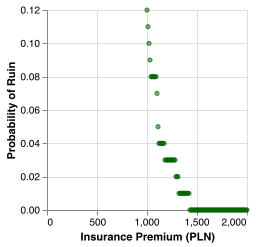

In [41]:
scatter = results_df |>
@vlplot(
    :point,
    x = {
        :premium,
        title = "Insurance Premium (PLN)",
        axis = {grid = true}
    },
    y = {
        :ruin_risk,
        title = "Probability of Ruin",
        axis = {grid = true}
    },
    tooltip = [:premium, :ruin_risk],
    color = {value = "darkgreen"},
    size = {value = 10}
)

**2. For what pairs of (surplus, insurance premium) the ruin probabiblity is higher than 1%? (analiza 2 parametrów)**

In [43]:
# Range
surplus_range = 0.0:500.0:20000.0
premium_range = 500.0:50.0:1500.0

results_df_2 = DataFrame(surplus=Float64[], premium=Float64[], ruin_risk=Float64[], avg_surplus=Float64[])

for s in surplus_range, p in premium_range
    result = sim_experiment(s, p, SIMULATION_NUMBER, CLIENTS_NUMBER,
                            avg_claim_count, AVG_CLAIM_AMOUNT_LN,
                            STD_CLAIM_AMOUNT_LN, TIME_HORIZON)

    push!(results_df_2, (s, p, result.insolvency_risk, result.surplus_condition_avg))
end

# Filter ruin risk > 1% 
risky_df = filter(:ruin_risk => r -> r > 0.01, results_df_2)

println("Pairs of surplus and premium that make the ruin risk greater than 1%::")
risky_df

Pairs of surplus and premium that make the ruin risk greater than 1%::


Row,surplus,premium,ruin_risk,avg_surplus
,Float64,Float64,Float64,Float64
1,0.0,500.0,0.75,-904.863
2,0.0,550.0,0.71,426.146
3,0.0,600.0,0.63,2014.12
4,0.0,650.0,0.6,4407.0
5,0.0,700.0,0.52,7647.85
6,0.0,750.0,0.42,10308.4
7,0.0,800.0,0.36,14056.9
8,0.0,850.0,0.32,17626.6
9,0.0,900.0,0.28,21581.6


In [44]:
describe(risky_df)
println("Number of pairs of surplus and premium that make the ruin risk greater than 1%: ", nrow(risky_df))

Number of pairs of surplus and premium that make the ruin risk greater than 1%: 696


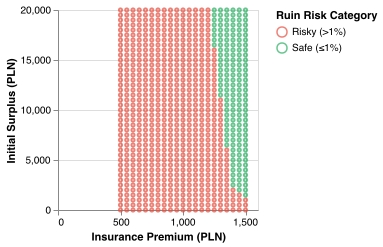

In [45]:
results_df_2[!, :risk_label] = ifelse.(results_df_2.ruin_risk .> 0.01, "Risky (>1%)", "Safe (≤1%)")

@vlplot(
    :point,
    data = results_df_2,
    x = {
        :premium,
        title = "Insurance Premium (PLN)"
    },
    y = {
        :surplus,
        title = "Initial Surplus (PLN)"
    },
    color = {
        :risk_label,
        title = "Ruin Risk Category",
        scale = {
            domain = ["Risky (>1%)", "Safe (≤1%)"],
            range = ["#e74c3c", "#27ae60"]
        }
    },
    tooltip = [:premium, :surplus, :ruin_risk],
    size = {value = 10}
)

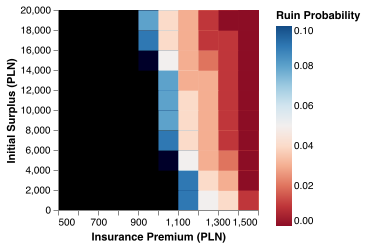

In [46]:
@vlplot(
    :rect,
    data = results_df_2,
    x = {
        :premium,
        bin = true,
        title = "Insurance Premium (PLN)"
    },
    y = {
        :surplus,
        bin = true,
        title = "Initial Surplus (PLN)"
    },
    color = {
        :ruin_risk,
        scale = {
            scheme = "redblue",
            domain = [0, 0.1]
        },
        title = "Ruin Probability"
    },
    tooltip = [:premium, :surplus, :ruin_risk]
)


**Interpretation of Results**
The simulation results clearly indicate that the probability of ruin decreases significantly when both the initial surplus and the insurance premium are high. This observation aligns with intuition, as an insurance company with: 
- a strong financial reserve (high surplus)
- a high and stable revenue stream from premiums (high premium)

is better equipped to absorb losses and maintain solvency over time.

On the other hand, scenarios with low surplus and low premium tend to have a significantly higher risk of ruin, sometimes exceeding 10%.

Notably, the analysis suggests that the insurance premium plays a more influential role than surplus in reducing the probability of ruin:
- In many cases, even with a moderate surplus, a sufficiently high premium is enough to ensure a low risk of ruin.
- Conversely, a high surplus combined with a low premium still results in considerable risk.

This highlights the critical importance of effective premium pricing strategies in managing insolvency risk—especially in volatile environments or when financial reserves are limited.

**3. What is the insurnace premium that results in the average final surplus being equal (on average) to the initial surplus? Ignore the risk of ruin by setting a very high initial surplus or commenting the line in the above code:  surplus < 0 && return surplus (it will not stop a simulation, if surplus is negative) in model definition.**

In [49]:
initial_surplus = 10000.0
premium_range = 400.0:10.0:2000.0

results_3 = DataFrame(premium = Float64[], avg_final_surplus = Float64[])

for premium in premium_range
    sim = sim_experiment(initial_surplus, premium, SIMULATION_NUMBER, 
                         CLIENTS_NUMBER, avg_claim_count, 
                         AVG_CLAIM_AMOUNT_LN, STD_CLAIM_AMOUNT_LN, TIME_HORIZON)

    push!(results_3, (premium = premium, avg_final_surplus = sim.surplus_condition_avg))
end

# Closest premium that have average final surplus ~ initial surplus
results_3.difference = abs.(results_3.avg_final_surplus .- initial_surplus)
sorted_results = sort(results_3, :difference)

# Optimal
println("Closest premium that have avg final surplus ~ initial surplus:")
println(first(sorted_results, 1))  

# Top 5
println("\nTop 5 closest premium:")
first(sorted_results, 5)

Closest premium that have avg final surplus ~ initial surplus:
1×3 DataFrame
 Row │ premium  avg_final_surplus  difference 
     │ Float64  Float64            Float64    
─────┼────────────────────────────────────────
   1 │   630.0            9894.17     105.833

Top 5 closest premium:


Row,premium,avg_final_surplus,difference
,Float64,Float64,Float64
1,630.0,9894.17,105.833
2,640.0,10511.4,511.386
3,620.0,9128.78,871.224
4,650.0,10967.2,967.2
5,610.0,8531.74,1468.26


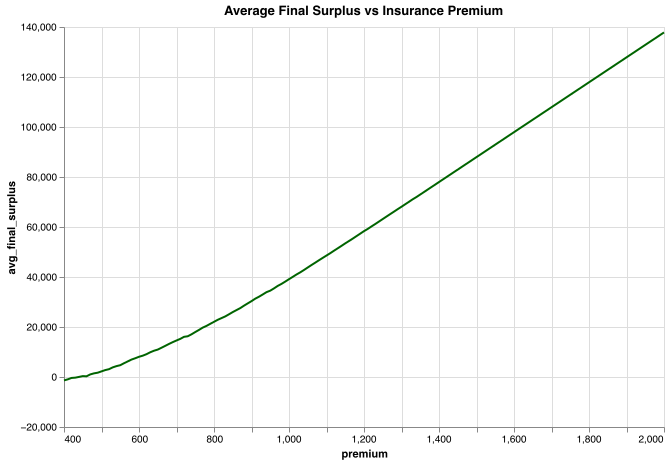

In [50]:
results_3 |> @vlplot(
    :line,
    x = "premium:q",
    y = "avg_final_surplus:q",
    width = 600,
    height = 400,
    color = {value = "darkgreen"},
    title = "Average Final Surplus vs Insurance Premium"
)

- The plot illustrates the relationship between the insurance premium and the average final surplus over the simulation horizon.
- This analysis is helpful in identifying a neutral pricing point where the insurer neither profits nor incurs losses on average—important for regulatory compliance or pricing transparency strategies.

**4. How the number of simulations impacts results? What minimum simulation number do you recommend? Is 100 simulations enough to get stable results? For instance, choose one of simulated metrics, e.g. final surplus or from (1) minimum insurance premium resulting in ruin risk lower than 1%. Demonstrate, how does this metrics dispersion mesure, e.g. standard deviation or quantiles, depend on simulation number. You can make a graph with number of simulation on X axis and dispersion measure on Y axis.**

In [93]:
sim_nums = 100:100:10000
initial_surplus = 10_000.0
insurance_premium = 1320.0  # optimal premium found in question 1
results_4 = DataFrame(simulation_number = Int[], std_dev = Float64[], 
                    q25 = Float64[], q50 = Float64[], q75 = Float64[])

for sim_n in sim_nums
    surpluses = Float64[]
    for seed in 1:sim_n
        s = model(CLIENTS_NUMBER, avg_claim_count, 
                  AVG_CLAIM_AMOUNT_LN, STD_CLAIM_AMOUNT_LN, 
                  TIME_HORIZON, initial_surplus, insurance_premium, seed=seed)
        push!(surpluses, s)
    end

    push!(results_4, (simulation_number = sim_n,
                    std_dev = std(surpluses),
                    q25 = quantile(surpluses, 0.25),
                    q50 = quantile(surpluses, 0.50),
                    q75 = quantile(surpluses, 0.75)))
end

println(results_4)

100×5 DataFrame
 Row │ simulation_number  std_dev  q25      q50      q75     
     │ Int64              Float64  Float64  Float64  Float64 
─────┼───────────────────────────────────────────────────────
   1 │               100  28697.3  51637.0  72636.0  93697.1
   2 │               200  30994.8  50575.1  69135.1  87494.3
   3 │               300  30851.6  49105.2  69135.1  88416.4
   4 │               400  30022.9  47780.9  69505.1  87379.3
   5 │               500  29914.9  50116.9  71577.3  87910.9
   6 │               600  29571.2  50697.0  72416.8  89454.3
   7 │               700  29333.1  50500.1  71790.7  89410.1
   8 │               800  28822.7  51618.7  72623.9  89757.4
   9 │               900  28930.1  51774.4  72398.8  89846.7
  10 │              1000  28998.9  52017.0  72843.0  90310.8
  11 │              1100  29100.3  52146.8  72974.9  90862.7
  12 │              1200  29223.0  51961.7  72910.1  91043.0
  13 │              1300  29133.4  51804.6  72843.0  90862.7
  14 

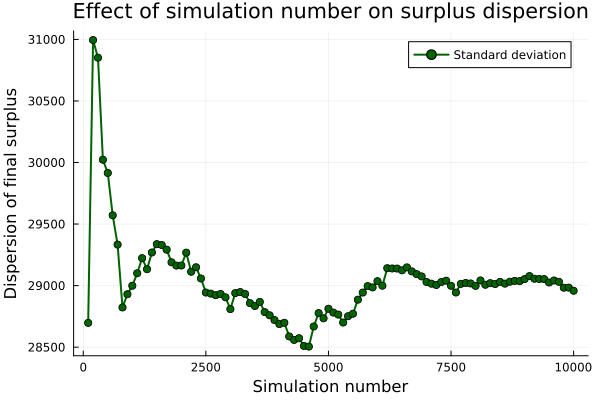

In [99]:
# Plot Standard Deviation vs Simulation Number
plot(results_4.simulation_number, results_4.std_dev,
     label="Standard deviation", lw=2, marker=:circle, color="darkgreen",
     xlabel="Simulation number", ylabel="Dispersion of final surplus",
     title="Effect of simulation number on surplus dispersion")

**=> The minimum number of simulations for dispersion to stabilize is about 800. At this level, the standard deviation and quantiles (q25, q50, q75) of the simulation results no longer fluctuate much as the number of simulations continues to increase. “Stable” here means that the important statistical indicators of the results do not change significantly anymore (fluctuation is less than 1%).**